### Available Methods
- Combinatorial
    - Exhaustive if $p \leq 10$.
    - Random Walk.
        - Randomly try matrices.
        - Transition to close matrix.
    - Metropolis Hastings.
- Continuous Optimization.
    - Gradient Descent.
    - LASSO-DAG
    - NO TEARS for VAR(1) models.
- Greedy
    - Forward
        - OMP
        - OLS
        - LiNGAM
    - Backward
        - OMP
        - OLS
        - LiNGAM
    - Backward - Violations First
        - OMP
        - OLS
        - LiNGAM

In [1]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from timeit import default_timer as timer
import itertools

from sklearn.linear_model import LassoLars, LassoLarsIC

In [103]:
reload(h);
reload(m);

[[ 0.72177356  0.          0.          0.        ]
 [ 0.          0.70025509  0.          0.        ]
 [ 0.60538429  0.          0.5511688   0.        ]
 [ 0.         -0.61637963  0.          0.55435967]]


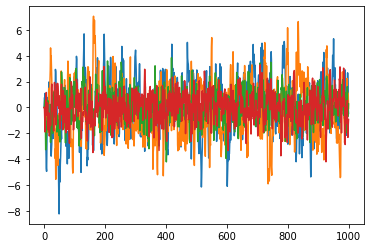

In [3]:
T, p = 1000, 4
m.T, m.p = T, p

W = h.generate_A(p, 2, tril = True, high = 0.75)
for i in range(p):
    W[i][i] = np.random.uniform(0.5, 0.75)
    
X = h.generate_var_2(T, p, W, np.identity(p))

print(W)
plt.plot(X);

In [4]:
m.p = p
m.rw_1(X[:-1], X[1:], np.identity(p), 100)
m.rw_2(X[:-1], X[1:], np.identity(p), 100)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1010.08it/s]


(array([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]]),
 array([[ 0.72023177, -0.00517737,  0.        ,  0.01844359],
        [ 0.        ,  0.71484614,  0.        ,  0.        ],
        [ 0.56977523, -0.01357922,  0.56679069,  0.03746847],
        [ 0.        , -0.60509005,  0.        ,  0.53470273]]),
 3.925932139342378)

### Exhaustive

In [5]:
def exh(X, Y, is_sem = False):
    perms = itertools.permutations(np.identity(p))
    total = np.math.factorial(p)

    Psi = X.T.dot(X)
    K   = X.T.dot(Y)

    P_best = np.identity(p)
    W_best = k_ols_W(Psi, K, P_best, is_sem = is_sem)
    L_best = loss(W_best, X, Y)

    for perm in tqdm(perms, total = total):
        perm = np.array(perm)
        W = k_ols_W(Psi, K, perm, is_sem = is_sem)
        L = loss(W, X, Y)

        if L < L_best:
            P_best, W_best, L_best = perm, W, L
            
    return P_best, W_best, L_best

In [6]:
P_best, W_best, L_best = exh(X[:-1], X[1:], is_sem = True)
print(f"Exhaustively best P:\n{P_best},\n\nExhaustively best W:\n{np.round(W_best, 2)},\n\nLikelihood: {round(L_best, 2)}.")

NameError: name 'k_ols_W' is not defined

In [ ]:
m.p = 4
P_best, W_best, L_best = m.exh(X[:-1], X[1:], is_sem = True)
print(f"Exhaustively best P:\n{P_best},\n\nExhaustively best W:\n{np.round(W_best, 2)},\n\nLikelihood: {round(L_best, 2)}.")

### RandomWalk

In [ ]:
def rw(X, Y, max_it, P, verbose = False, total_time = 1e10, is_sem = False):
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    
    n, p = np.shape(X)

    start = timer()
    
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = loss(k_ols_W(Psi, K, P, is_sem = is_sem), X, Y) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P_2(P)

        W = k_ols_W(Psi, K, P_prime, is_sem = is_sem)
        L = loss(W, X, Y)

        if L < L_best:
            P_best, W_best, L_best = P_prime, W, L

    return P_best, W_best, L_best

In [ ]:
P_best, W_best, L_best = rw(X[:-1], X[1:], 100, np.identity(p))

### MCMC

In [173]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()

    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)

    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]

    # return new sample
    return P_return

def sample_next_P_2(P):  
    # get copy
    return np.random.permutation(np.identity(p))

def loss(W, X, Y):
    return 1 / len(X) * np.linalg.norm(Y - X @ W, 'f') ** 2

def expected_MSE_X(W):
    return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def true_loss(W_est, W_true):
    return np.trace((W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est- np.identity(p)))

def get_likelihood(P, X, Y):
    # get optimal A for this permutation
    W_opt = k_ols_W(Psi, K, P)

    # get loss    
    return loss(k_ols_W(Psi, K, P), X, Y)

def k_ols_W(Psi, K, P, is_sem = True):
    # translate X
    psi = P @ Psi @ P.T
    k = P @ K @ P.T

    W_hat = np.zeros((p, p))

    # get parameters
    if is_sem:
        for i in range(1, p):
            psi_F = psi[np.array(range(i))[:, None], np.array(range(i))[None, :]]   
            W_hat[np.array(range(i))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i))[:, None], i]
    else: 
        for i in range(p):
            psi_F = psi[np.array(range(i+1))[:, None], np.array(range(i+1))[None, :]]   
            W_hat[np.array(range(i+1))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i+1))[:, None], i]

    return P.T @ W_hat @ P

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k, L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new):
    return L_new < L

def mcmc(X, Y, max_it, P, verbose = False, factor = 1.0, total_time = 1e10, is_sem = False):
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    
    n, p = np.shape(X)

    start = timer()
    
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = loss(k_ols_W(Psi, K, P, is_sem = is_sem), X, Y) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = loss(k_ols_W(Psi, K, P_prime, is_sem = is_sem), X, Y)
        alpha = acc_prob_greed(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        # check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        # num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    if verbose:
        print(transitions)
        print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")

    W_best = k_ols_W(Psi, K, P_best, is_sem)
    return P_best, W_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

In [ ]:
P_mcmc, W_mcmc, r = mcmc(X[:-1], X[1:], int(1e3), np.identity(p), is_sem = True);
print(W_mcmc)
m.mcmc(X[:-1], X[1:], int(1e3), np.identity(p), is_sem = True, v = 0);
print(f"Loss: {round(loss(W_mcmc, x, y), 3)}.")

### LASSO DAG

In [7]:
def lasso_lars_W(X, alpha):
    """Performs LASSO with Lars on X with regularization value alpha"""
    
    # get regressor and variables
    y = X[1:]
    x = X[:-1]

    # initialize W_hat
    W_hat = np.array([])

    # Get our regularization method
    reg = LassoLars(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(p):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    # return W_hat after reshape
    return W_hat.reshape((p, p)).T

In [8]:
def lingnam_lasso_lars(X, step_size = 0.1):
    """Incrementally increase penalty by step_size until we have aa DAG"""
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # while we do not have a dag
    while not h.is_dag(W_hat):
        # increase alpha and do lasso with increased alpha
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)

    # return W_hat and print smallest alpha
    print(f"Smallest alpha for DAG: {round(alpha, 5)}.")
    return W_hat

In [9]:
# lasso_lars_W(X, 0.5)
lingnam_lasso_lars(X, step_size = 0.05)

Smallest alpha for DAG: 0.1.


array([[ 0.70684076,  0.        ,  0.        ,  0.00737089],
       [ 0.        ,  0.6995847 ,  0.        ,  0.        ],
       [ 0.50918787,  0.        ,  0.49965059,  0.        ],
       [ 0.        , -0.53547026,  0.        ,  0.45990038]])

### NOTEARS VAR

In [10]:
m._notears_2(X, lambda1 = 0.3)

(array([[ 0.68389237,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.67389051,  0.        ,  0.        ],
        [ 0.38800349,  0.        ,  0.36625042,  0.        ],
        [ 0.        , -0.39147297,  0.        ,  0.30536677]]),
 0.0)

### DAG-OMP

In [11]:
print(np.shape(X))

x = np.vstack((X[:-1], X[-1]))
print(np.shape(x))

(1000, 4)
(1000, 4)


In [12]:
m._OLS(X)



array([[ 0.71754074, -0.00517737, -0.0092429 ,  0.02004769],
       [-0.01492501,  0.71484614,  0.00348762,  0.01725087],
       [ 0.57090236, -0.01357922,  0.57189051,  0.03659479],
       [ 0.01136466, -0.60509005, -0.01843458,  0.54247175]])

In [13]:
m.p = p
m._K_OMP(X[:-1], X[1:])

(array([[ 0.72023177, -0.00517737,  0.        ,  0.01844359],
        [ 0.        ,  0.71484614,  0.        ,  0.        ],
        [ 0.56977523, -0.01357922,  0.56679069,  0.03746847],
        [ 0.        , -0.60509005,  0.        ,  0.53470273]]),
 3922.0062072030405)

### OLS-DAG

In [14]:
def expected_cost_var(W_true, W_est):
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

In [15]:
T, p = 250, 10
m.T, m.p = T, p

W = h.generate_A_2(p, 5, tril = True, high = 0.75)
W = np.random.permutation(W)
for i in range(p):
    W[i][i] = np.random.uniform(0.25, 0.50)

print(W)

covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))

X = h.generate_var_2(T, p, W, np.identity(p))
iters = 1000
datasets = [X]

# for each dataset
for dataset in datasets:
    # for each method:
    T, p = np.shape(dataset)
    
    # 1: Exhaustive:
    if p < 10:
        W_exh = m.exh(X[:-1], X[1:])
        
    # 2.1: Random Walk 1, need regularizing
    W_rw_1 = con_LASSO(X, m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1] != 0)
    _, _, _, _, shd_rw_1, mse_rw_1, _ = h.score(X, W_rw_1, W, printing = False)
    error_rw_1 = expected_cost_var(W, W_rw_1)
    print("Random Walk: Close permutations.")
    print(f"SHD: {shd_rw_1}, Empirial Risk: {round(mse_rw_1, 3)}, True Risk: {round(error_rw_1, 3)}.")
    
    # 2.2: Random Walk 2
    W_rw_2 = con_LASSO(X, m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1] != 0)
    _, _, _, _, shd_rw_2, mse_rw_2, _ = h.score(X, W_rw_2, W, printing = False)
    error_rw_2 = expected_cost_var(W, con_OLS(X, W_rw_2 != 0))
    print("Random Walk: Any permutations.")
    print(f"SHD: {shd_rw_2}, Empirial Risk: {round(mse_rw_2, 3)}, True Risk: {round(error_rw_2, 3)}.")
    
    # 3.1: MCMC 1
    W_mcmc_1 = con_LASSO(X, m.mcmc_1(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_1, mse_mcmc_1, _ = h.score(X, W_mcmc_1, W, printing = False)
    error_mcmc_1 = expected_cost_var(W, con_OLS(X, W_mcmc_1 != 0))
    print("MCMC: Regular.")
    print(f"SHD: {shd_mcmc_1}, Empirial Risk: {round(mse_mcmc_1, 3)}, True Risk: {round(error_mcmc_1, 3)}.")
    
    # 3.2: MCMC 2
    W_mcmc_2 = con_LASSO(X, m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_2, mse_mcmc_2, _ = h.score(X, W_mcmc_2, W, printing = False)
    error_mcmc_2 = expected_cost_var(W, con_OLS(X, W_mcmc_2 != 0))
    print("MCMC: Translated.")
    print(f"SHD: {shd_mcmc_2}, Empirial Risk: {round(mse_mcmc_2, 3)}, True Risk: {round(error_mcmc_2, 3)}.")
    
    # 3.3: MCMC 3
    W_mcmc_3 = con_LASSO(X, m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_3, mse_mcmc_3, _ = h.score(X, W_mcmc_3, W, printing = False)
    error_mcmc_3 = expected_cost_var(W, con_OLS(X, W_mcmc_3 != 0))
    print("MCMC: Squared.")
    print(f"SHD: {shd_mcmc_3}, Empirial Risk: {round(mse_mcmc_3, 3)}, True Risk: {round(error_mcmc_3, 3)}.")
    
    # 3.4: MCMC 4
    W_mcmc_4 = con_LASSO(X, m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_4, mse_mcmc_4, _ = h.score(X, W_mcmc_4, W, printing = False)
    error_mcmc_4 = expected_cost_var(W, con_OLS(X, W_mcmc_4 != 0))
    print("MCMC: Greedy.")
    print(f"SHD: {shd_mcmc_4}, Empirial Risk: {round(mse_mcmc_4, 3)}, True Risk: {round(error_mcmc_4, 3)}.")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
    W_notears, _ = m.notears_2(X, lambda1 = 0.1)
    _, _, _, _, shd_notears, mse_notears, _ = h.score(X, W_notears, W, printing = False)
    error_notears = expected_cost_var(W, con_OLS(X, W_notears != 0))
    print("NO TEARS.")
    print(f"SHD: {shd_notears}, Empirial Risk: {round(mse_notears, 3)}, True Risk: {round(error_notears, 3)}.")
    
    # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
    W_lassodag, _ = m._LASSO_LINGNAM(X, step_size = 1)
    _, _, _, _, shd_lassodag, mse_lassodag, _ = h.score(X, W_lassodag, W, printing = False)
    error_lassodag = expected_cost_var(W, con_OLS(X, W_lassodag != 0))
    print("DAG-LASSO.")
    print(f"SHD: {shd_lassodag}, Empirial Risk: {round(mse_lassodag, 3)}, True Risk: {round(error_lassodag, 3)}.")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
    W_omp, _ = m._K_OMP(X[:-1], X[1:], F = [], normalize = True)
    _, _, _, _, shd_omp, mse_omp, _ = h.score(X, W_omp, W, printing = False)
    error_omp = expected_cost_var(W, con_OLS(X, W_omp != 0))
    print("DAG-OMP.")
    print(f"SHD: {shd_omp}, Empirial Risk: {round(mse_omp, 3)}, True Risk: {round(error_omp, 3)}.")
    
    # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
    W_olsdag, _ = m._OLS_LINGNAM(X)  
    _, _, _, _, shd_olsdag, mse_olsdag, _ = h.score(X, W_olsdag, W, printing = False)
    error_olsdag = expected_cost_var(W, con_OLS(X, W_olsdag != 0))
    print("DAG-OLS.")
    print(f"SHD: {shd_olsdag}, Empirial Risk: {round(mse_olsdag, 3)}, True Risk: {round(error_olsdag, 3)}.")

90
[[ 0.33726769  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.25167881  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.32618091  0.          0.          0.
   0.          0.          0.66076182  0.        ]
 [ 0.          0.          0.          0.49000775  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.34562615  0.
   0.         -0.69176956  0.          0.        ]
 [ 0.          0.          0.          0.63429049  0.          0.30475513
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.42425054  0.          0.          0.        ]
 [ 0.         -0.74008674  0.          0.          0.          0.
   0.          0.26211129  0.          0.        ]
 [ 0.          0.          0.          0.          0.

NameError: name 'con_LASSO' is not defined

In [16]:
help(m._LASSO_LINGNAM)

Help on function _LASSO_LINGNAM in module helper.methods:

_LASSO_LINGNAM(X, step_size=0.01, normalize=False)
    Incrementally increase penalty by step_size until we have a DAG



In [17]:
def con_OLS(X, B):
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

In [18]:
def con_LASSO(X, B, criterion = 'aic', alpha = 0.01):
    
    T, p = np.shape(X)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, )
    
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    
    clf = LassoLarsIC(criterion = criterion, fit_intercept = False, normalize = False, )
    clf.fit(X_large, y_large)
    
    return con_OLS(X, clf.coef_.reshape(p, p).T != 0)

In [19]:
W_omp, _ = m._K_OMP(X[:-1], X[1:], normalize = True, F = [])
h.score(X, con_LASSO(X, W_omp != 0, criterion = 'aic'), W)
print()
h.score(X, con_LASSO(X, W_omp != 0, criterion = 'bic'), W)

True Positive Rate: 1.0.
True Negative Rate: 0.884.
False Prediction Rate: 0.417
Accuracy: 0.9.
R-Squared: 0.348
Mean Squared Error: 9.839

True Positive Rate: 1.0.
True Negative Rate: 0.942.
False Prediction Rate: 0.263
Accuracy: 0.95.
R-Squared: 0.345
Mean Squared Error: 9.879


(1.0,
 0.9418604651162791,
 0.2631578947368421,
 0.95,
 5,
 9.879226046666508,
 0.3449375213985533)

[0.79288586 0.64540994 0.62525912 0.68576297 0.70030537 0.73102955
 0.67035561 0.76681234 0.67595279 0.66696889]
[[ 0.7  0.   0.   0.   0.   0.   0.   0.5  0.   0. ]
 [ 0.   0.8  0.   0.5  0.   0.5 -0.5  0.5  0.   0.5]
 [-0.5  0.   0.6  0.5  0.5  0.   0.   0.   0.   0.5]
 [ 0.5  0.   0.   0.7  0.5  0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.7  0.   0.   0.5  0.5  0. ]
 [-0.5  0.   0.   0.   0.   0.7  0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.7  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.7  0.   0. ]
 [-0.5  0.   0.   0.   0.   0.   0.   0.5  0.8  0. ]
 [ 0.   0.   0.   0.5  0.   0.5 -0.5  0.  -0.5  0.6]]


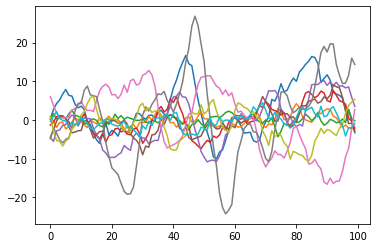

In [164]:
T, p = 100, 10
reload(m)
m.T, m.p = T, p

W = np.zeros((p, p))
W = h.generate_A(p, 25, tril = True, low = 0.5, high = 0.5)

for i in range(p):
    W[i][i] = np.random.uniform(0.6, 0.8)


covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
print(np.linalg.eig(W)[0])

P = np.random.permutation(np.identity(p))
W = P @ W @ P.T
print(np.round(W, 1))
X = h.generate_var_2(2 * T, p, W, np.identity(p))[T:]
plt.plot(X)
covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))

In [178]:
# 1: Exhaustive:
# if p < 10:
#     _, W_exh, _ = m.exh(X[:-1], X[1:])
#     _, _, _, _, shd_exh, mse_exh, _ = h.score(X, W_exh, W, printing = False)
#     error_exh = expected_cost_var(W, W_exh)
#     print("Exhaustive.")
#     print(f"SHD: {shd_exh}, Empirial Risk: {round(mse_exh, 3)}, True Risk: {round(error_exh, 3)}.")

iters = 1000
# # 2.1: Random Walk 1, need regularizing
W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
print(np.round(W_rw_1, 2))
_, _, _, _, shd_rw_1, mse_rw_1, _ = h.score(X, W_rw_1, W, printing = False)
error_rw_1 = expected_cost_var(W, W_rw_1)
print("Random Walk: Close permutations.")
print(f"SHD: {shd_rw_1}, Empirial Risk: {round(mse_rw_1, 3)}, True Risk: {round(error_rw_1, 3)}.")

# 2.2: Random Walk 2
W_rw_2 = m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1]
print(np.round(W_rw_2, 1))
_, _, _, _, shd_rw_2, mse_rw_2, _ = h.score(X, W_rw_2, W, printing = False)
error_rw_2 = expected_cost_var(W, con_OLS(X, W_rw_2 != 0))
print("Random Walk: Any permutations.")
print(f"SHD: {shd_rw_2}, Empirial Risk: {round(mse_rw_2, 3)}, True Risk: {round(error_rw_2, 3)}.")

  3%|██▋                                                                            | 34/1000 [00:00<00:02, 336.63it/s]

[[ 0.67  0.    0.01  0.    0.    0.    0.    0.45  0.    0.  ]
 [ 0.19  0.73 -0.01  0.34 -0.24  0.55 -0.56  0.5   0.05  0.32]
 [ 0.    0.    0.53  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.42  0.    0.13  0.86  0.53  0.   -0.5   0.25  0.04  0.02]
 [-0.03  0.   -0.08  0.    0.7   0.    0.05  0.47  0.51  0.  ]
 [-0.52  0.    0.1   0.05 -0.03  0.86 -0.02 -0.46  0.56 -0.03]
 [-0.07  0.    0.01  0.    0.    0.    0.7   0.08  0.54  0.  ]
 [ 0.    0.   -0.02  0.    0.    0.    0.    0.69  0.    0.  ]
 [-0.5   0.    0.03  0.    0.    0.    0.    0.47  0.8   0.  ]
 [-0.09  0.   -0.17  0.    0.1   0.   -0.51 -0.19 -0.44  0.73]]
Random Walk: Close permutations.
SHD: 24, Empirial Risk: 11.435, True Risk: 13.484.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.07it/s]

[[ 0.7  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.7 -0.1  0.3 -0.2  0.5 -0.5  0.6 -0.   0. ]
 [-0.5  0.   0.6  0.   0.3  0.1  0.1  0.  -0.2  0. ]
 [ 0.5  0.   0.   0.7  0.5 -0.1 -0.5  0.5  0.1  0. ]
 [-0.   0.   0.   0.   0.7  0.   0.   0.7  0.5  0. ]
 [-0.5  0.   0.   0.  -0.1  0.7  0.  -0.6  0.6  0. ]
 [-0.   0.   0.   0.  -0.1 -0.   0.7  0.3  0.6  0. ]
 [-0.   0.   0.   0.   0.   0.   0.   0.8  0.   0. ]
 [-0.5  0.   0.   0.   0.   0.   0.  -0.1  0.8  0. ]
 [-0.  -0.  -0.   0.6  0.1  0.5 -0.6 -0.5 -0.4  0.8]]
Random Walk: Any permutations.
SHD: 14, Empirial Risk: 11.617, True Risk: 15.587.


Random Walk: Close permutations.
SHD: 40, Empirial Risk: 12.528, True Risk: 13.457.

Random Walk: Any permutations.
SHD: 17, Empirial Risk: 11.816, True Risk: 12.909.

In [169]:
import numpy as np
import itertools
from tqdm import tqdm
def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    perms = []
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0]))):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            perms.append(P)
            
    # return the number of suitable permutations
    return perms, total


P_imp, total_P = get_permutations(W)

3628800it [08:20, 7248.22it/s]


In [177]:
Psi = X[:-1].T.dot(X[:-1])
K   = X[:-1].T.dot(X[1:])

P_best = np.identity(p)
W_best = k_ols_W(Psi, K, P_best, is_sem = False)
L_best = loss(W_best, X[:-1], X[1:])

for perm in P_imp:
    perm = np.array(perm.T)
    W = k_ols_W(Psi, K, perm, is_sem = False)
    L = loss(W, X[:-1], X[1:])

    if L < L_best:
        P_best, W_best, L_best = perm, W, L
            
print(L_best)

9.426235341952689


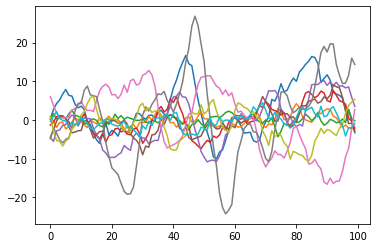

In [180]:
plt.plot(X);

In [186]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

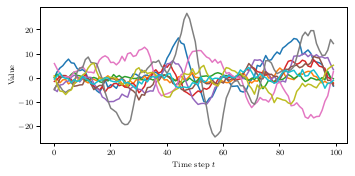

In [187]:
## Plot series
fig = plt.figure(figsize = (5.5, 2.5))
fig.patch.set_alpha(0)
plt.xlabel(r"Time step $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 
# plt.legend(plots, [r"$X_1$", r"$X_2$", r"$X_3$"], loc = 1);
plt.savefig('figure random walk example.pgf')

In [191]:
help(h.save_data)
h.save_data(X, W, "RW_ex", "this data was used in the random walk example.")

Help on function save_data in module helper.helper:

save_data(X, W, misc, expl, directory='')
    Saves dataset X, matrix W

Dataset saved with name X_s55_n100_T10_RW_ex_0.


C:\Users\s165048\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [192]:
def con_LASSO(X, B, criterion = 'aic', alpha = 0.01):
    
    T, p = np.shape(X)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, )
    
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    
    clf = LassoLarsIC(criterion = criterion, fit_intercept = False, normalize = False, )
    clf.fit(X_large, y_large)
    
    return con_OLS(X, clf.coef_.reshape(p, p).T != 0)

In [196]:
con_LASSO(X, W != 0, criterion = 'bic')

array([[ 0.78247574,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.21862479,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.92530615,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.74221889,
         0.        ,  0.        ,  0.24528817,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.90814394,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.17846587,
         0.        ,  0.96614017,  0.        

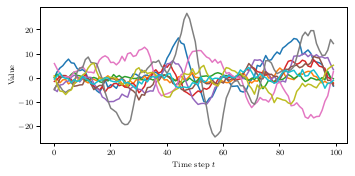

In [198]:
## Plot series
fig = plt.figure(figsize = (5.5, 2.5))
fig.patch.set_alpha(0)
plt.xlabel(r"Time step $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 
# plt.legend(plots, [r"$X_1$", r"$X_2$", r"$X_3$"], loc = 1);
plt.savefig('figure random walk example_v2.pgf', bbox_inches = 'tight')